In [1]:
from UTILITY_quickstart import *

importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline.yml")

In [2]:
csrTF = True


bunchCount = importedDefaultSettings["bunchCount"]

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
    
    csrTF = csrTF,
    numMacroParticles=1e5,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

setLattice(tao, **importedDefaultSettings)
launchTwissCorrection(tao)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0
Beam created, written to /tmp/beams/activeBeamFile_8746098923493413660.h5, and reinit to tao
No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [28.77865964 13.39705392 23.51276157 16.83077823]
Objective Function Value at Optimal Parameters: 3.875225216013324e-12
Number of Iterations: 354
Converged: True


In [3]:
trackStart = "ENDBC14E"
trackEnd = "PR15944"

trackBeam(tao, trackEnd = trackStart, **importedDefaultSettings)

PStart = getBeamAtElement(tao, trackStart)

makeBeamActiveBeamFile( PStart, tao = tao )



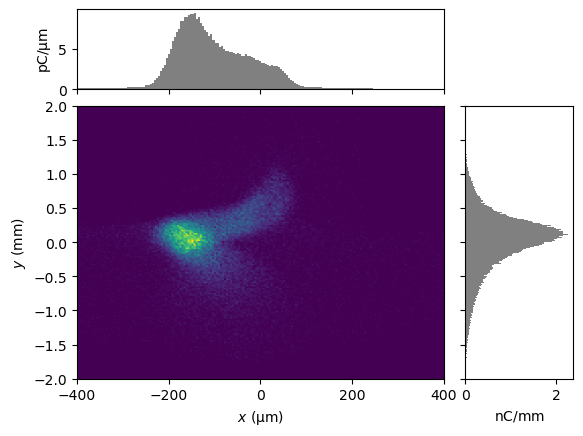

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:498: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


{'PDrive_median_x': -0.00011686550255435532,
 'PDrive_median_y': 6.508999364941973e-05,
 'PDrive_median_xp': -1.3184978415020094e-05,
 'PDrive_median_yp': -4.871856175456884e-06,
 'PDrive_sigmaSI90_x': 8.605442480867553e-05,
 'PDrive_sigmaSI90_y': 0.00046712502748095754,
 'PDrive_sigmaSI90_z': 3.810478892587508e-05,
 'PDrive_sigmaSI90_xp': 1.2125619873810391e-05,
 'PDrive_sigmaSI90_yp': 2.9751350345986383e-05,
 'PDrive_emitSI90_x': 8.487248692120432e-06,
 'PDrive_emitSI90_y': 2.4962962115023758e-05,
 'PDrive_norm_emit_x': 5.6022034338433665e-06,
 'PDrive_norm_emit_y': 5.092463072285982e-06,
 'PDrive_charge_nC': 1.5996480000000006}

<Figure size 640x480 with 0 Axes>

In [4]:
tao.cmd(f"set ele TCY15280 VOLTAGE = 20e6")
tao.cmd(f"set ele TCY15280 PHI0 = {0/360.0}")

trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)


P = getBeamAtElement(tao, trackEnd)
display(plotMod(P, 'x', 'y', bins=300, xlim = (-0.4e-3, 0.4e-3), ylim = (-2e-3,2e-3)))
plt.clf()

getBeamSpecs(P)

## Scan

In [5]:
data = []
quadStep = 10
allQuadSettings = np.arange(-60, 0 + quadStep, quadStep)

for quadSetting in allQuadSettings:
    setQuadkG(tao, "Q14901", quadSetting)

    # trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)

    # P = getBeamAtElement(tao, trackEnd)

    # fileName = f"/Users/nmajik/{quadSetting}.png"
    # print(fileName)
    
    # fig = plotMod(P, 'x', 'y', bins=300, xlim = (-0.4e-3, 0.4e-3), ylim = (-2e-3,2e-3))

    # fig.savefig(fileName)


    transferMatrix = getMatrix(tao, trackStart, trackEnd)

    trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)

    P = getBeamAtElement(tao, trackEnd)
    
    #spotSize = smallestIntervalImpliedSigma(P.x)
    spotSize = P["sigma_x"]

    data.append(
        {
            "quadSetting" : quadSetting,
            "R11" : transferMatrix[0][0],
            "R12" : transferMatrix[0][1],
            "sigma" : spotSize,
            "beam" : P
        }
    )

    

In [6]:
P["mean_energy"]

5538390599.573305

In [7]:
getSingleBeamSlice( P, sortKey = "y", minVal = 0, maxVal = 100e-6 ) 

<ParticleGroup with 9735 particles at 0x165e33590>

In [8]:
generalizedEmittanceSolver( data, energyGeV = 4.5 )

{'beta': 6.716863607952076,
 'alpha': 0.34684406820012215,
 'emitGeo': 1.8570949942188206e-09,
 'emit': 1.6354065506819363e-05}

In [9]:
PStart.twiss(fraction = 0.95)

{'alpha_x': 0.31615930345485505,
 'beta_x': 5.502582575956689,
 'gamma_x': 0.19989826412915188,
 'emit_x': 7.709864295482278e-10,
 'eta_x': -0.0025078275101138763,
 'etap_x': -3.858309071927697e-05,
 'norm_emit_x': 6.685128101281603e-06}

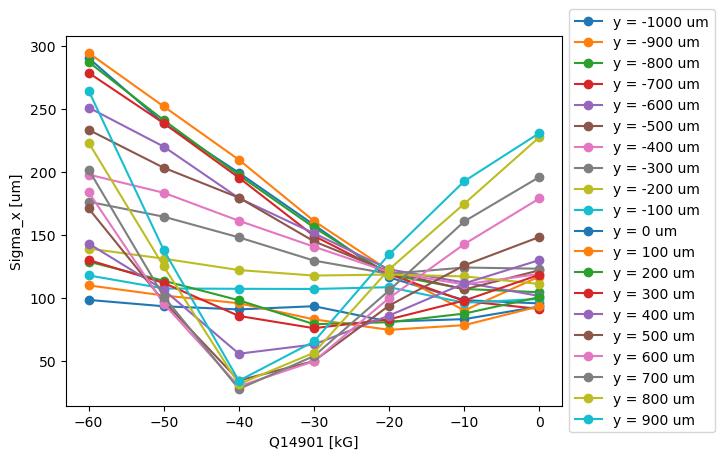

In [10]:
for binStartum in np.arange(-1000, 1000, 100):
    activeSigmaArr = []
    for row in data:
        PTmp = getSingleBeamSlice(row["beam"], sortKey="y", minVal=(binStartum/1e6), maxVal=((binStartum + 100)/1e6))
        activeSigmaArr.append(PTmp["sigma_x"])
    
    plt.plot(allQuadSettings, 1e6 * np.array(activeSigmaArr), marker='o', linestyle='-', label=f'y = {binStartum} um')

plt.xlabel("Q14901 [kG]")
plt.ylabel("Sigma_x [um]")

# Move the legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

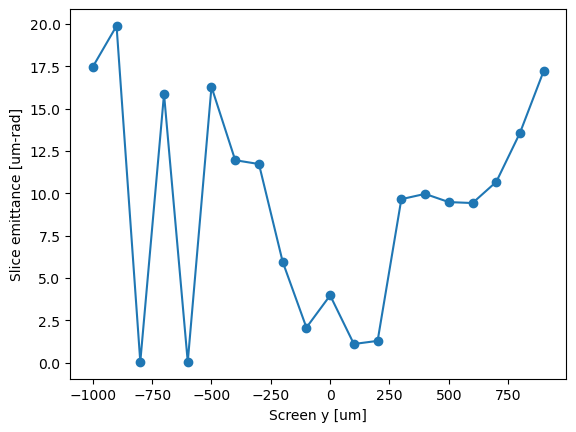

In [11]:
allBinStartum = np.arange(-1000, 1000, 100)
calculatedSliceEmittances = []


for binStartum in allBinStartum:
    activeData = []
    for row in data:
        
        PTmp = getSingleBeamSlice(row["beam"], sortKey="y", minVal=(binStartum/1e6), maxVal=((binStartum + 100)/1e6))
        
        activeData.append(
            {
                "R11" : row["R11"],
                "R12" : row["R12"],
                "sigma" : PTmp["sigma_x"]
            }
        )

    calculatedSliceEmittances.append( generalizedEmittanceSolver( activeData, energyGeV = 4.5 )["emit"] ) 


plt.plot(allBinStartum, 1e6 * np.array(calculatedSliceEmittances), marker='o', linestyle='-')

plt.xlabel("Screen y [um]")
plt.ylabel("Slice emittance [um-rad]")


plt.show()

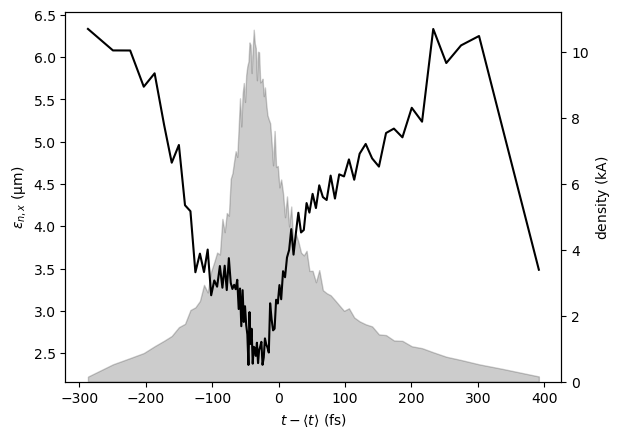

In [12]:
display(slicePlotMod(PStart, 'norm_emit_x', slice_key = "delta_t", n_slice=100))

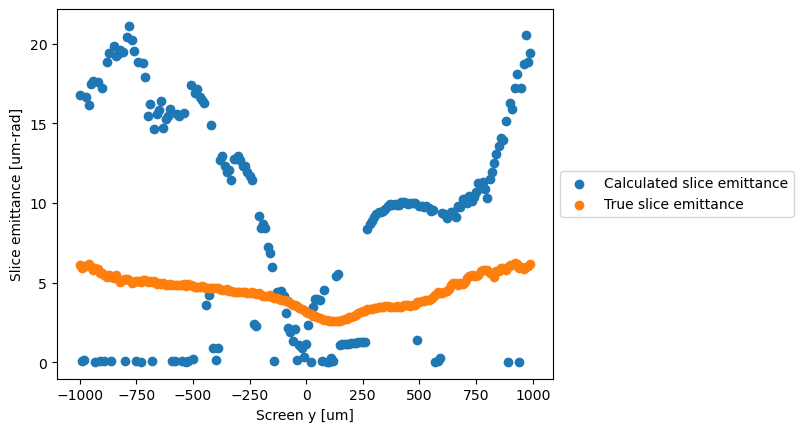

In [13]:
plt.clf() 

ySliceHalfWidth = 50e-6

#Note that some signs are flipped below because this is negative!
resolution = -2.4412906612140807e-10 #seconds/meter

allBinCenters = np.arange(-1e-3, 1e-3, 10e-6)
calculatedSliceEmittances = []
actualSliceEmittances = []

for binCenter in allBinCenters:


    
    activeData = []
    for row in data:
        
        PTmp = getSingleBeamSlice(row["beam"], sortKey="y", minVal=(binCenter - ySliceHalfWidth), maxVal=(binCenter + ySliceHalfWidth))

        #Sanity check by slicing in time
        #PTmp = getSingleBeamSlice(row["beam"], sortKey="delta_t", minVal=(binCenter + ySliceHalfWidth)*resolution, maxVal=(binCenter - ySliceHalfWidth)*resolution)
        
        activeData.append(
            {
                "R11" : row["R11"],
                "R12" : row["R12"],
                "sigma" : PTmp["sigma_x"]
            }
        )

    calculatedSliceEmittances.append( generalizedEmittanceSolver( activeData, energyGeV = 4.5 )["emit"] )   


    
    PTmp = getSingleBeamSlice(PStart, sortKey="delta_t", minVal=(binCenter + ySliceHalfWidth)*resolution, maxVal=(binCenter - ySliceHalfWidth)*resolution)
    
    actualSliceEmittances.append( PTmp.twiss()["norm_emit_x"] )




#plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(calculatedSliceEmittances), marker='o', label = "Calculated slice emittance (magic t slices)")
plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(calculatedSliceEmittances), marker='o', label = "Calculated slice emittance")
plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(actualSliceEmittances), marker='o', label = "True slice emittance" )

plt.xlabel("Screen y [um]")
plt.ylabel("Slice emittance [um-rad]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()




## Two quads moving in tandem

See "2025-02-13 Processing Q14891 and Q14901 data.nb"

Aim is to keep y beta function fixed while still changing x

In [129]:
setQuadkG(tao, "Q14901",  -31.3)

data = []
quadStep = 10
allQuadSettings = np.arange(0, 60 + quadStep, quadStep)

# quadStep = 10
# allQuadSettings = np.arange(20, 40 + quadStep, quadStep)

for QM14891Set in allQuadSettings:
    Q14901Set = -10 - (4/5) * QM14891Set
    
    setQuadkG(tao, "QM14891", QM14891Set)
    setQuadkG(tao, "Q14901",  Q14901Set)



    transferMatrix = getMatrix(tao, trackStart, trackEnd)

    trackBeam(tao, trackStart = trackStart, trackEnd = trackEnd, **importedDefaultSettings)

    P = getBeamAtElement(tao, trackEnd)
    
    #spotSize = smallestIntervalImpliedSigma(P.x)
    spotSize = P["sigma_x"]

    data.append(
        {
            "QM14891Set" : QM14891Set,
            "Q14901Set" : Q14901Set,
            "R11" : transferMatrix[0][0],
            "R12" : transferMatrix[0][1],
            "sigma" : spotSize,
            "beam" : P
        }
    )

In [130]:
# from scipy.optimize import differential_evolution


def generalizedEmittanceSolverObjective(params, data):
    betaI, alphaI, emittanceGeo = params
    
    errorComponents = []

    for shot in data:
        # Twiss transfer matrix for beta
        # R11^2 \[Beta] - 2 R11 R12 \[Alpha] +  + R12^2 \[Gamma]
        term1 = betaI * shot["R11"] ** 2
        term2 = -2 * alphaI * shot["R11"] * shot["R12"]
        term3 =  ( (1 + alphaI ** 2) / betaI ) * shot["R12"] ** 2

        # (beta * emit_geo) == sigma^2
        errorComponent = ( term1 + term2 + term3 ) * emittanceGeo - shot["sigma"] ** 2

        #Add all error terms in quadrature
        errorComponents.append(errorComponent ** 2)
    
        
    
    return np.median(errorComponents)


# def generalizedEmittanceSolver(
#     data,
#     energyGeV = None,
#     verbose = False,
#     initialGuess = [0.5, 0.5, 1e-9],
#     **kwargs
# ):
#     """
#     `data` should be a list of dictionaries, each of which should contain at least "R11", "R12", and "sigma" corresponding to the R-matrix terms for the transfer of interest
#     and the beam sigma at the downstream screen.

#     The the initial beta, alpha, and emittance are used as fit parameters to explain the observations
#     The typical Twiss transfer is applied for each case and compared to the observed spot size

#     If this isn't giving the values you expect, make sure the single-particle Twiss values are what you expect! (Consider running launchTwissCorrection())
#     """
    
#     from scipy.optimize import minimize


#     result = differential_evolution(
#         generalizedEmittanceSolverObjective, 
#         [ (0, 1e2), (-1e2, 1e2), (0, 1e-6) ],
#         args = (data, ),
#         **kwargs
#     )


#     if verbose:
#         print("Optimization Results:")
#         print(f"Optimal Parameters: {result.x}")
#         print(f"Objective Function Value at Optimal Parameters: {result.fun}")
#         print(f"Number of Iterations: {result.nit}")
#         print(f"Converged: {result.success}")

#     output = {"beta" : result.x[0], "alpha" : result.x[1], "emitGeo" : result.x[2]}

#     if energyGeV:
#         #Sloppy, ultrarel only
#         output["emit"] = result.x[2] * energyGeV * 1000 / 0.511
    
#     return output


# def generalizedEmittanceSolverObjective(params, data):
#     betaI, alphaI, emittanceGeo = params
    
#     errorComponents = []

#     for shot in data:
#         # Twiss transfer matrix for beta
#         # R11^2 \[Beta] - 2 R11 R12 \[Alpha] +  + R12^2 \[Gamma]
#         term1 = betaI * shot["R11"] ** 2
#         term2 = -2 * alphaI * shot["R11"] * shot["R12"]
#         term3 =  ( (1 + alphaI ** 2) / betaI ) * shot["R12"] ** 2

#         # (beta * emit_geo) == sigma^2
#         errorComponent = ( term1 + term2 + term3 ) * emittanceGeo - shot["sigma"] ** 2

#         #Add all error terms in quadrature
#         errorComponents.append(errorComponent ** 2)
    
        
    
#     return np.sum(errorComponents)

def generalizedEmittanceSolver(
    data,
    energyGeV = None,
    verbose = False,
    initialGuess = [0.5, 0.5, 1e-9],
    **kwargs
):
    """
    `data` should be a list of dictionaries, each of which should contain at least "R11", "R12", and "sigma" corresponding to the R-matrix terms for the transfer of interest
    and the beam sigma at the downstream screen.

    The the initial beta, alpha, and emittance are used as fit parameters to explain the observations
    The typical Twiss transfer is applied for each case and compared to the observed spot size

    If this isn't giving the values you expect, make sure the single-particle Twiss values are what you expect! (Consider running launchTwissCorrection())
    """
    
    from scipy.optimize import minimize


    # Perform optimization using Nelder-Mead
    result = minimize(
        generalizedEmittanceSolverObjective, 
        initialGuess, #Starting point
        method='Nelder-Mead',
        args = (data, ),
        **kwargs
    )


    if verbose:
        print("Optimization Results:")
        print(f"Optimal Parameters: {result.x}")
        print(f"Objective Function Value at Optimal Parameters: {result.fun}")
        print(f"Number of Iterations: {result.nit}")
        print(f"Converged: {result.success}")

    output = {"beta" : result.x[0], "alpha" : result.x[1], "emitGeo" : result.x[2]}

    if energyGeV:
        #Sloppy, ultrarel only
        output["emit"] = result.x[2] * energyGeV * 1000 / 0.511
    
    return output

In [141]:
ySliceHalfWidth = 50e-6

#Note that some signs are flipped below because this is negative!
resolution = -2.4412906612140807e-10 #seconds/meter

allBinCenters = np.arange(-1e-3, 1e-3, 10e-6)
calculatedSliceEmittances = []
actualSliceEmittances = []

for binCenter in allBinCenters:


    
    activeData = []
    for row in data:
        
        PTmp = getSingleBeamSlice(row["beam"], sortKey="y", minVal=(binCenter - ySliceHalfWidth), maxVal=(binCenter + ySliceHalfWidth))

        #Sanity check by slicing in time
        #PTmp = getSingleBeamSlice(row["beam"], sortKey="delta_t", minVal=(binCenter + ySliceHalfWidth)*resolution, maxVal=(binCenter - ySliceHalfWidth)*resolution)
        
        activeData.append(
            {
                "R11" : row["R11"],
                "R12" : row["R12"],
                "sigma" : PTmp["sigma_x"]
                #"sigma" : smallestIntervalImpliedSigma(PTmp.x)
            }
        )

    calculatedSliceEmittances.append( generalizedEmittanceSolver( activeData, energyGeV = 4.5, initialGuess = [0.5, 0.5, 1e-9],  verbose = False )["emit"] )   


    
    PTmp = getSingleBeamSlice(PStart, sortKey="delta_t", minVal=(binCenter + ySliceHalfWidth)*resolution, maxVal=(binCenter - ySliceHalfWidth)*resolution)
    
    actualSliceEmittances.append( PTmp.twiss()["norm_emit_x"] )
    #actualSliceEmittances.append( smallestIntervalImpliedEmittance(PTmp) )




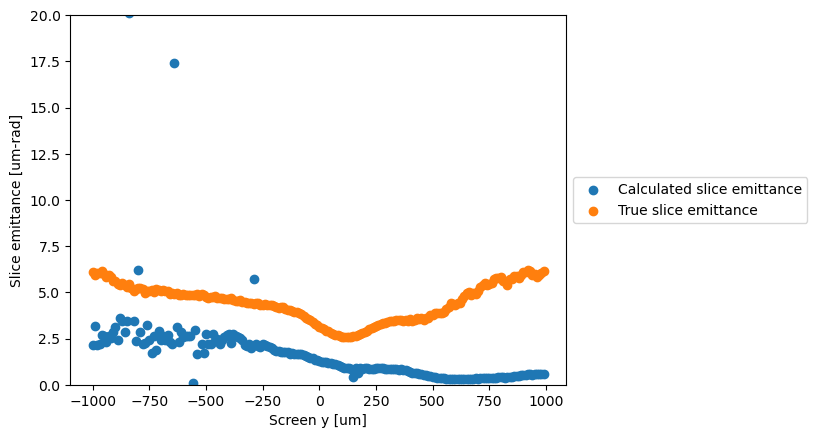

In [142]:
plt.clf() 

#plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(calculatedSliceEmittances), marker='o', label = "Calculated slice emittance (magic t slices)")
plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(calculatedSliceEmittances), marker='o', label = "Calculated slice emittance")
plt.scatter(1e6 * np.array(allBinCenters), 1e6 * np.array(actualSliceEmittances), marker='o', label = "True slice emittance" )

plt.xlabel("Screen y [um]")
plt.ylabel("Slice emittance [um-rad]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax = plt.gca()
ax.set_ylim([0, 20])

plt.show()

